# CS421 PROJECT

## Loading and Merging of datasets

In [11]:
import numpy as np
import pandas as pd

# Load the data
data=np.load("week_9_data/training_data_with_labels.npz")
data_new = np.load("week_10_data/first_batch_test_with_labels.npz")
data_new_2 = np.load("week_11_data/second_batch_test_with_labels.npz")

 # Week 9
X_existing = data["X"]
y_existing = data["y"]

# Week 9 data is shifted by 100
X_existing[:, 0] = X_existing[:, 0] - 100
y_existing[:, 0] = y_existing[:, 0] - 100

# Week 10
X_new = data_new["X"]
y_new = data_new["y"]

# Week 11
X_new_2 = data_new_2["X"]
y_new_2 = data_new_2["y"]

In [12]:
# Combine the data from all weeks
X = np.concatenate((X_existing, X_new, X_new_2), axis=0)
y = np.concatenate((y_existing, y_new, y_new_2), axis=0)

print("# of interactions:", X.shape[0])
print("# of anomalous and normal users:", np.count_nonzero(y==1), np.count_nonzero(y==0))

XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
print("# of items:", XX['item'].unique().shape[0])

# of interactions: 608091
# of anomalous and normal users: 321 3101
# of items: 1199


In [13]:
yy.rename(columns={0:"user",1:"label"},inplace=True)
yy.head()

,user,label
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


## Preprocessing

In [14]:
# Merge the data by user
merged_data = pd.merge(XX, yy, on='user', how='left')
merged_data.head()

,user,item,rating,label
0,99,0,3,0
1,99,4,5,0
2,99,7,4,0
3,99,12,4,0
4,99,13,5,0


In [15]:
# Group the data by user
groups_X = merged_data.groupby('user')
groups_X = [group for _, group in groups_X]

### Preprocessing for Feature Engineering

In [16]:
new_data = merged_data[['item']] 
 
values = new_data['item'].value_counts(normalize=True, dropna=False).keys().tolist() 
counts = new_data['item'].value_counts(normalize=True, dropna=False).tolist() 
popularity_index = dict(zip(values, counts))

item_counts = merged_data[['item','label']].groupby('item').value_counts(normalize=True) 
 
plotting_table = item_counts.unstack(level=1) 
 
plotting_table = plotting_table.reset_index() 
 
plotting_table = plotting_table.fillna(0) 
 
anomalous_items = np.array(plotting_table[plotting_table[1]>=0.5]['item'])

max_rating_global = merged_data['rating'].max()
min_rating_global = merged_data['rating'].min()
avg_rating_global = merged_data['rating'].mean()

In [17]:
item_groups = merged_data.groupby('item')
item_groups = [group for _, group in item_groups]

item_df = pd.DataFrame(columns=["item", "interactions"])

for item in range(len(item_groups)):
    new_row = {"item": item, "interactions": len(item_groups[item])}
    item_df.loc[len(item_df.index)] = new_row

top_threshold = item_df["interactions"].quantile(0.9)
bottom_threshold = item_df["interactions"].quantile(0.15)
popular_items = list(item_df[item_df['interactions'] >= top_threshold].index)
unpopular_items = list(item_df[item_df['interactions'] <= bottom_threshold].index)

### Feature Engineering

In [18]:
features_list = []

for group in groups_X:
    label = group['label'].iloc[0] # Ground truth label of the user

    min_rating = group['rating'].min() # Min rating given by the user
    total_interactions = group.shape[0] # Total number of interactions by the user

    fsti = total_interactions / merged_data['item'].nunique() # The ratio between the number of items rated by the user and the total number of items in the recommender system.
    fsmaxrti = (group['rating'] == max_rating_global).sum() / total_interactions # The ratio between the number of items rated by the user with maximum score and the total number of items in the recommender system.
    fsminrti = (group['rating'] == min_rating_global).sum() / total_interactions # The ratio between the number of items rated by the user with minimum score and the total number of items in the recommender system.

    unique_items = group['item'].nunique() # Count how many times each user rated items exactly at their max or min rating

    score = 0
    for item in group['item']:
        score = score + item # Sum of the items' ratings rated by the user

    popularity_score = 0 
 
    for item in group['item']: 
        if popularity_index.get(item): 
            popularity_score += popularity_index.get(item) # A score reflecting the sum of the popularity of items interacted with by the user.

    rating_variance = group['rating'].var() # The variance of the ratings given by the user

    has_popular_item = 0
    has_unpopular_item = 0
    for item in group['item']: 
        if item in popular_items:
            has_popular_item += 1
        if item in unpopular_items:
            has_unpopular_item += 1

    fspi = has_popular_item / len(popular_items) # The ratio between the number of popular items rated by the user and the total number of popular items, K, in the recommender system.
    fspii = has_popular_item / len(group["item"]) # The ratio between the number of popular items rated by the user and the total number of items rated by the user.

    features_list.append({
        'label': label,
        'min_rating': min_rating,
        'fsti': fsti,
        'fsmaxrti': fsmaxrti,
        'fsminrti': fsminrti,
        'total_interactions': total_interactions,
        'score': score,
        'popularity_score': popularity_score,
        'rating_variance': rating_variance,
        'unique_items': unique_items,
        "fspi": fspi,
        "fspii": fspii,
    }),


features_df = pd.DataFrame(features_list)
features_df.head()

,label,min_rating,fsti,fsmaxrti,fsminrti,total_interactions,score,popularity_score,rating_variance,unique_items,fspi,fspii
0,1,1,0.073394,0.079545,0.000000,88,39401,0.144835,0.977926,88,0.250000,0.340909
1,0,0,0.302752,0.049587,0.198347,363,149754,0.487970,2.168820,363,0.791667,0.261708
2,0,2,0.043369,0.480769,0.000000,52,5189,0.094272,0.710407,52,0.183333,0.423077
3,0,2,0.144287,0.005780,0.000000,173,120615,0.209635,0.321347,173,0.291667,0.202312
4,0,1,0.076731,0.402174,0.000000,92,55434,0.142000,0.767678,92,0.233333,0.304348


## Visualisation of Features (Users vs Anomalous Users)

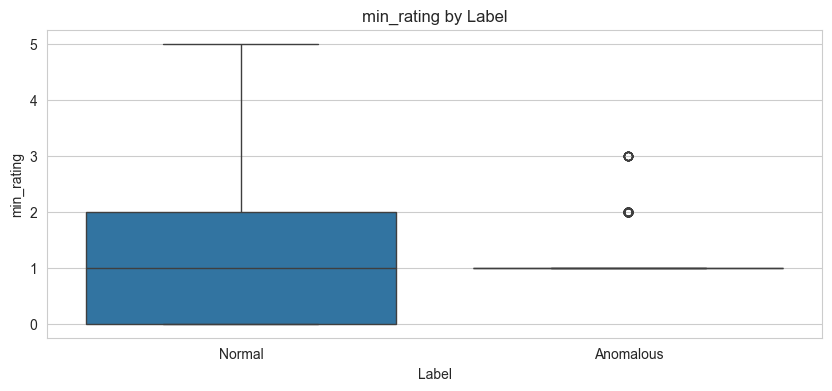

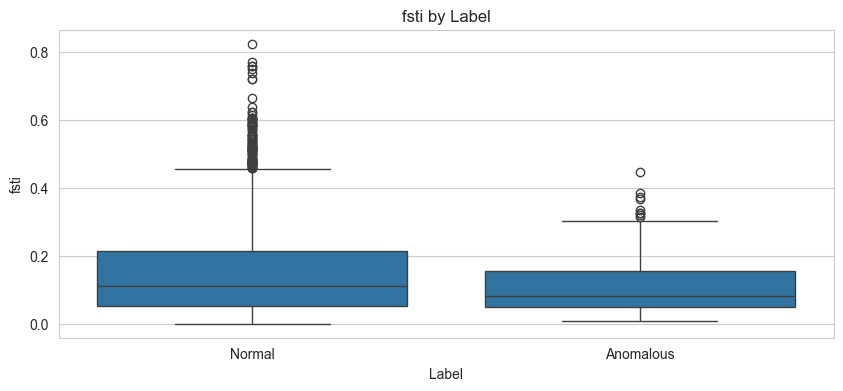

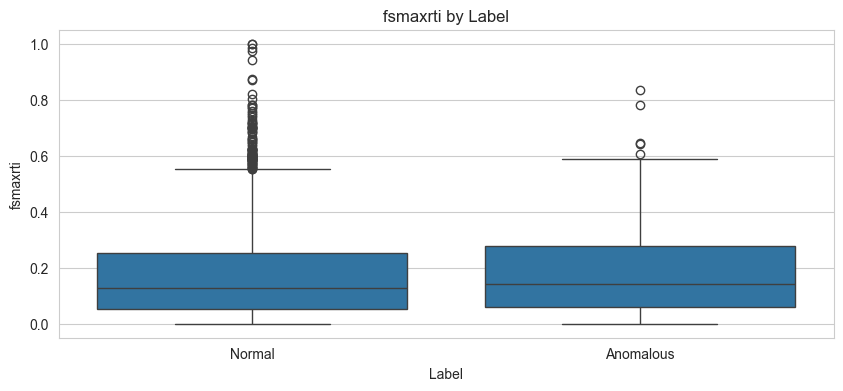

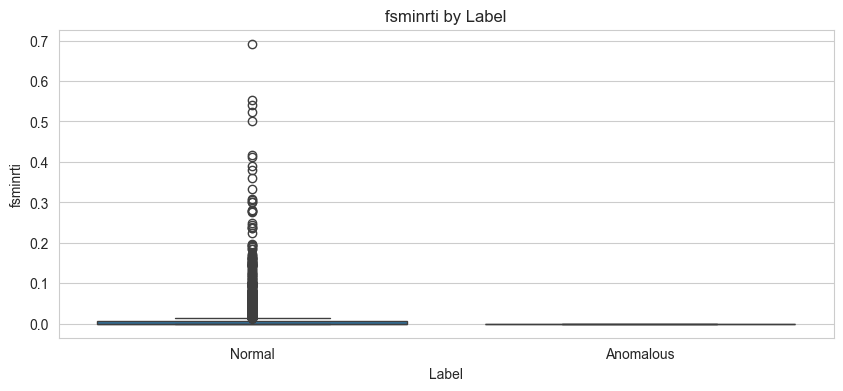

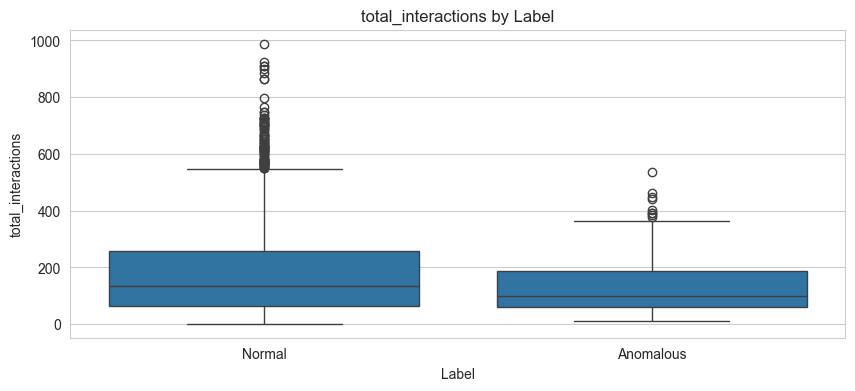

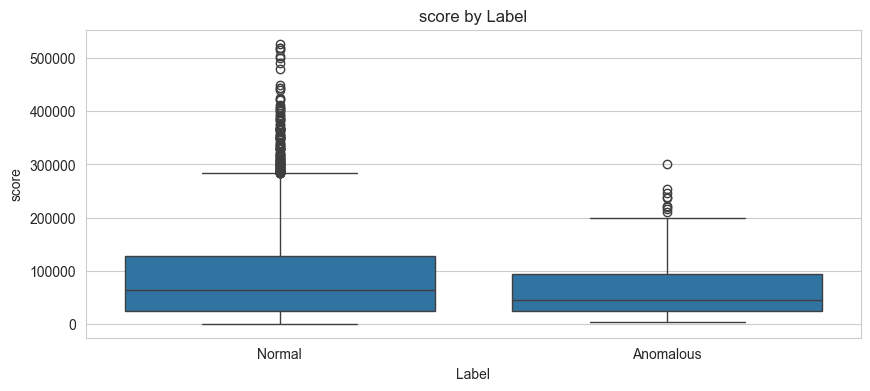

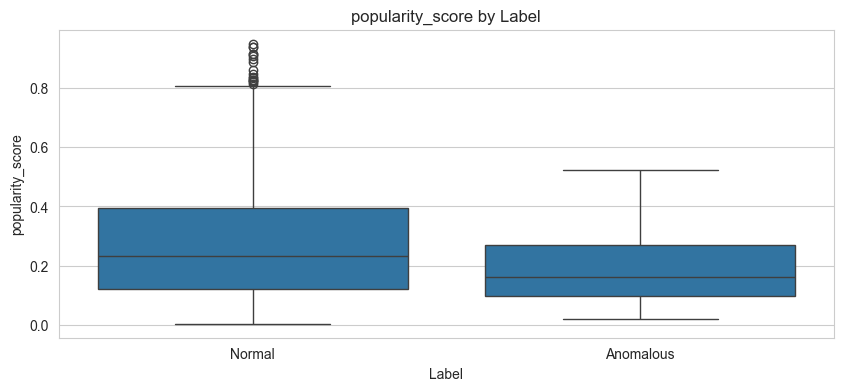

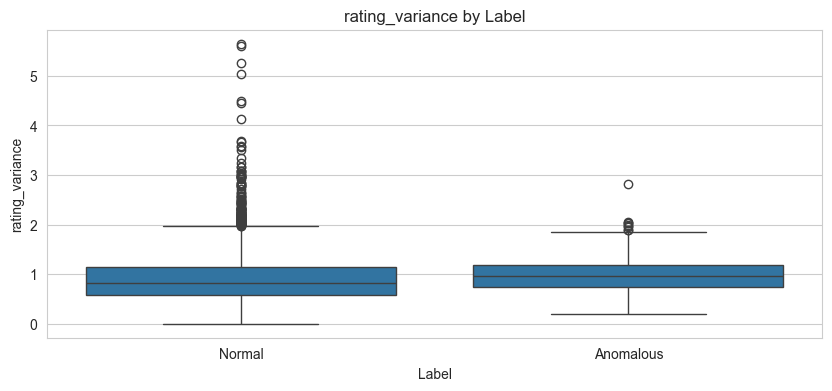

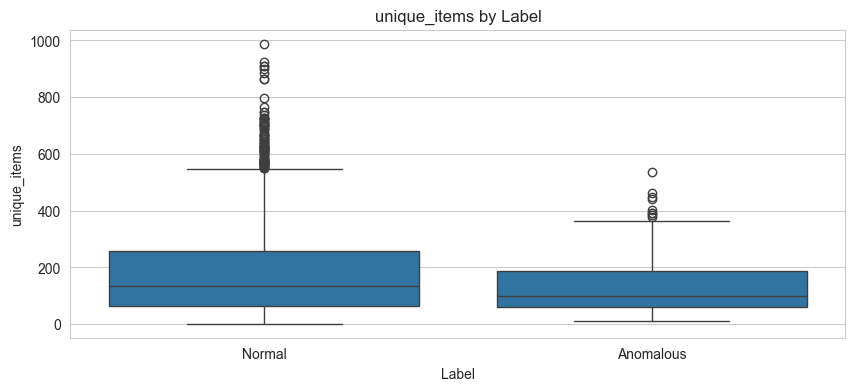

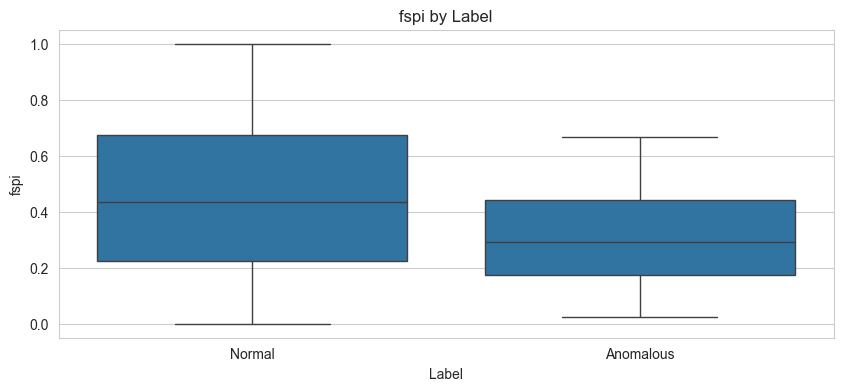

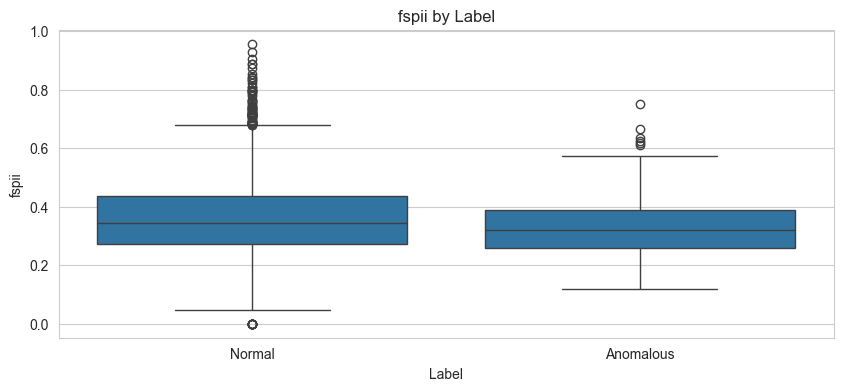

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Plot boxplots
for feature in features_df.columns[1:]:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
    plt.xlabel('Label')
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Normal', 'Anomalous'])
    plt.show()

## Deep Neural Network Architecture

In [20]:
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def build_model(n_features, l2_value):
    model = Sequential()
    model.add(Dense(64, activation='elu', kernel_regularizer=regularizers.l2(l2_value), input_shape=(n_features,))) # Ridge regularisation
    model.add(BatchNormalization())
    model.add(Dense(32, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='roc_auc', curve='ROC')]) # Using ROC AUC as the evaluation metric
    model.summary()
    return model

/Users/timothylee/Library/Python/3.10/lib/python/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Further Preprocessing with SMOTE and Normalisation

In [21]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Split the data into input features and labels
X = features_df.drop(['label'], axis=1)
y = features_df['label']

# Split the data into training and testing sets with stratification
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the input features
scaler = StandardScaler()
X_main = scaler.fit_transform(X_main)
X_test = scaler.transform(X_test)

X_main = pd.DataFrame(X_main)
X_main.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.128251,-0.782944,1.860977,-0.285671,-0.782944,-0.656968,-0.727673,-0.344065,-0.782944,-0.614788,1.532351
1,-0.028323,-0.735690,0.598790,-0.285671,-0.735690,-0.658736,-0.755135,-0.227150,-0.735690,-0.741418,0.624786
2,-1.184896,-0.796445,1.962050,0.159001,-0.796445,-0.721437,-0.847120,0.386567,-0.796445,-0.836391,0.753271
3,-1.184896,1.383978,-0.304449,-0.216991,1.383978,0.827579,1.325732,0.370237,1.383978,1.347979,-0.858143
4,-0.028323,-0.796445,5.264959,-0.285671,-0.796445,-0.982257,-0.924105,-1.283793,-0.796445,-1.089651,-0.305757


### 5-fold Stratified CV for Hyperparameter Tuning

In [22]:
# Define L1 values to test 
l1_values = [0.001, 0.003, 0.005, 0.008]
best_l1 = l1_values[0]
best_auc = -np.inf

n_features = X_main.shape[1]

In [23]:
for l1_value in l1_values:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_index, val_index in skf.split(X_main, y_main):
        X_train, X_val = X_main.iloc[train_index], X_main.iloc[val_index]
        y_train, y_val = y_main.iloc[train_index], y_main.iloc[val_index]
        
        # Balance the training set
        oversampler = SMOTE(random_state=42)
        X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
        
        # Build and fit the model
        model = build_model(n_features, l1_value)
        model.fit(X_resampled, y_resampled, batch_size=32, epochs=50, validation_data=(X_val, y_val),
                  callbacks=[EarlyStopping(monitor="val_roc_auc", patience=5, mode='max', restore_best_weights=True)])
        
        # Evaluate the model
        y_pred = model.predict(X_val).ravel()
        auc_score = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc_score)
    
    average_auc = np.mean(auc_scores)
    print(f"L1 value: {l1_value}, Average Validation AUC: {average_auc}")
    
    if average_auc > best_auc:
        best_auc = average_auc
        best_l1 = l1_value

print(f"Best L1 value: {best_l1}")
full_model = build_model(n_features, best_l1)

# Oversample the full dataset with SMOTE
oversampler = SMOTE(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_main, y_main)

# Fit the model on the full training dataset
full_model.fit(X_main, y_main, batch_size=32, epochs=50, callbacks=[EarlyStopping(monitor="roc_auc", patience=5, mode='max', restore_best_weights=True)]) # Early stopping based on ROC AUC

2024-04-02 20:47:02.998451: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-02 20:47:02.998471: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-02 20:47:02.998477: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-02 20:47:02.998526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-02 20:47:02.998562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_2 (Bat  (None, 16)                6

2024-04-02 20:47:03.848003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 3s 23ms/step - loss: 0.6154 - roc_auc: 0.7719
Epoch 2/50
86/86 [==============================] - 2s 19ms/step - loss: 0.4535 - roc_auc: 0.8336
Epoch 3/50
86/86 [==============================] - 2s 20ms/step - loss: 0.3479 - roc_auc: 0.8456
Epoch 4/50
86/86 [==============================] - 2s 21ms/step - loss: 0.2838 - roc_auc: 0.8740
Epoch 5/50
86/86 [==============================] - 2s 19ms/step - loss: 0.2569 - roc_auc: 0.8733
Epoch 6/50
86/86 [==============================] - 2s 20ms/step - loss: 0.2359 - roc_auc: 0.8952
Epoch 7/50
86/86 [==============================] - 2s 20ms/step - loss: 0.2304 - roc_auc: 0.8888
Epoch 8/50
86/86 [==============================] - 2s 20ms/step - loss: 0.2189 - roc_auc: 0.9024
Epoch 9/50
86/86 [==============================] - 2s 20ms/step - loss: 0.2114 - roc_auc: 0.9083
Epoch 10/50
86/86 [==============================] - 2s 20ms/step - loss: 0.2054 - roc_auc: 0.9154
Epoch 11/50
86/86 [===========

In [24]:
# Evaluate the model on the test set
full_model.evaluate(X_test, y_test)

22/22 [==============================] - 1s 15ms/step - loss: 0.1949 - roc_auc: 0.9123


[0.19487763941287994, 0.9123488068580627]

### ROC AUC Plot with Best Threshold

22/22 [==============================] - 0s 5ms/step
Best F1 Score: 0.5825 at Threshold: 0.4551


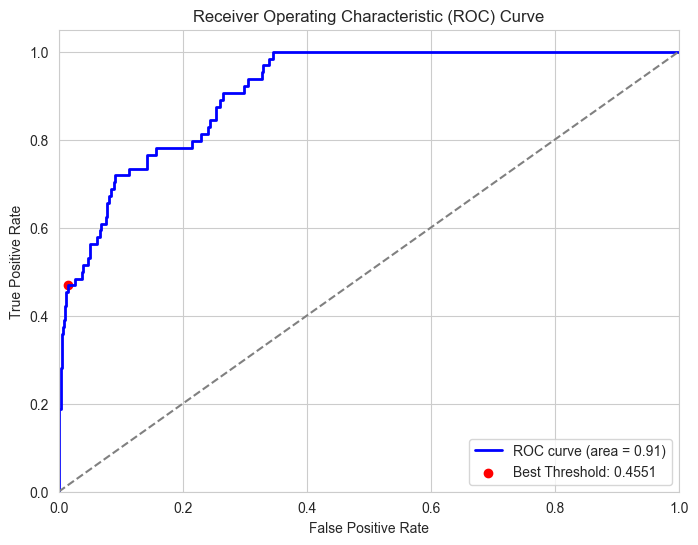

In [25]:
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt

y_pred_prob = full_model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Initialise variables to store the best F1 score and the corresponding best threshold
best_f1 = 0
best_threshold = 0.5
best_fpr = 0
best_tpr = 0

# Iterate over thresholds to find the best one for F1 score
for i, threshold in enumerate(thresholds):
    y_pred = (y_pred_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_fpr = fpr[i]
        best_tpr = tpr[i]

# Print the best F1 score and its corresponding threshold
print(f"Best F1 Score: {best_f1:.4f} at Threshold: {best_threshold:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(best_fpr, best_tpr, color='red', label=f'Best Threshold: {best_threshold:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## One-Class Support Vector Machine (SVM)

### 5-fold CV for Hyperparameter Tuning

In [26]:
from sklearn.svm import OneClassSVM

# Define the nu values to test
nu_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_nu = 0
best_svm_auc = -np.inf

In [27]:
for nu_value in nu_values:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, val_index in skf.split(X_main, y_main):
        X_train, X_val = X_main.iloc[train_index], X_main.iloc[val_index]
        y_train, y_val = y_main.iloc[train_index], y_main.iloc[val_index]
        
        # Build and fit the model
        svm_model = OneClassSVM(nu=nu_value, kernel='rbf', gamma = 'auto')
        svm_model.fit(X_train)
        
        # Evaluate the model
        y_pred = svm_model.predict(X_val)
        auc_score = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc_score)

    average_auc = np.mean(auc_scores)
    print(f"Nu value: {nu_value}, AUC: {average_auc}")

    if average_auc > best_svm_auc:
        best_svm_auc = average_auc
        best_nu = nu_value

Nu value: 0.1, AUC: 0.5431293485135991
Nu value: 0.2, AUC: 0.5672027806159685
Nu value: 0.3, AUC: 0.591276212718338
Nu value: 0.4, AUC: 0.614031406607308
Nu value: 0.5, AUC: 0.6360686396146548
Nu value: 0.6, AUC: 0.6389836641852771
Nu value: 0.7, AUC: 0.64533462268282
Nu value: 0.8, AUC: 0.6243501556950323
Nu value: 0.9, AUC: 0.5764134189656012


In [28]:
# Use the best nu value to build the final model
full_svm_model = OneClassSVM(nu=best_nu, kernel='rbf', gamma='auto')

# Fit the model on the full training dataset
full_svm_model.fit(X_main)

OneClassSVM(gamma='auto', nu=0.7)

### ROC AUC Plot with Best Threshold

Best F1 Score: 0.2455 at Threshold: 1.0000


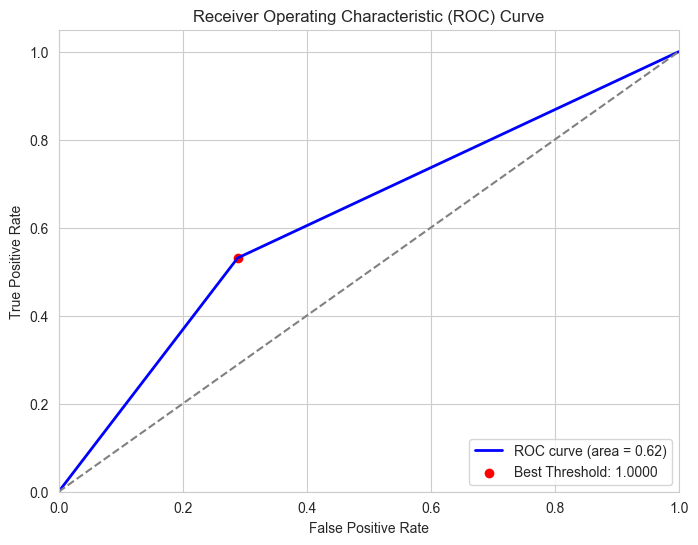

0.6212701612903225


In [29]:
y_pred_prob = full_svm_model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Initialise variables to store the best F1 score and the corresponding best threshold
best_f1 = 0
best_threshold = 0.5
best_fpr = 0
best_tpr = 0

# Iterate over thresholds to find the best one for F1 score
for i, threshold in enumerate(thresholds):
    y_pred = (y_pred_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_fpr = fpr[i]
        best_tpr = tpr[i]

# Print the best F1 score and its corresponding threshold
print(f"Best F1 Score: {best_f1:.4f} at Threshold: {best_threshold:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(best_fpr, best_tpr, color='red', label=f'Best Threshold: {best_threshold:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print(roc_auc)

# Logistic Regression

### 5-fold CV for Hyperparameter Tuning

In [30]:
from sklearn.linear_model import LogisticRegression

# Define the hyperparameters to test
c_values = [100, 10, 1.0, 0.1, 0.01]
penalties = ["none", "l1", "l2", "elasticnet"]
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
best_auc = 0
best_c_value = None
best_penalty = None
best_solver = None

In [31]:
for c_value in c_values:
    for penalty in penalties:
        for solver in solvers:
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            auc_scores = []
            for train_index, val_index in skf.split(X_main, y_main):
                X_train, X_val = X_main.iloc[train_index], X_main.iloc[val_index]
                y_train, y_val = y_main.iloc[train_index], y_main.iloc[val_index]
                # Balance the training set
                oversampler = SMOTE(random_state=42)
                X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

                try:
                    # Build and fit the model
                    model = LogisticRegression(max_iter=5000,penalty=penalty, C=c_value, solver=solver)
                    model.fit(X_train, y_train)
                except:
                    continue
            
                # Evaluate the model
                y_pred = model.predict(X_val)
                auc_score = roc_auc_score(y_val, y_pred)
                auc_scores.append(auc_score)

            if len(auc_scores) == 0:
                continue
            
            average_auc = np.mean(auc_scores)

            print(f"C Value: {c_value}, Penalty: {penalty}, Solver: {solver}, Average Validation AUC: {average_auc}")

            if average_auc > best_auc:
                best_auc = average_auc
                best_c_value = c_value
                best_penalty = penalty
                best_solver = solver

print(f"Best C Value: {best_c_value}, Best Penalty: {best_penalty},  Best Solver: {best_solver}, Average Validation AUC: {average_auc}")

C Value: 100, Penalty: l1, Solver: liblinear, Average Validation AUC: 0.5122588551549652
C Value: 100, Penalty: l1, Solver: saga, Average Validation AUC: 0.5122588551549652
C Value: 100, Penalty: l2, Solver: newton-cg, Average Validation AUC: 0.5120572422517393
C Value: 100, Penalty: l2, Solver: lbfgs, Average Validation AUC: 0.5120572422517393
C Value: 100, Penalty: l2, Solver: liblinear, Average Validation AUC: 0.5120572422517393
C Value: 100, Penalty: l2, Solver: sag, Average Validation AUC: 0.5122588551549652
C Value: 100, Penalty: l2, Solver: saga, Average Validation AUC: 0.512460468058191
C Value: 10, Penalty: l1, Solver: liblinear, Average Validation AUC: 0.5118556293485136
C Value: 10, Penalty: l1, Solver: saga, Average Validation AUC: 0.5122588551549652
C Value: 10, Penalty: l2, Solver: newton-cg, Average Validation AUC: 0.5104996837444655
C Value: 10, Penalty: l2, Solver: lbfgs, Average Validation AUC: 0.5104996837444655
C Value: 10, Penalty: l2, Solver: liblinear, Average Va

In [32]:
# Split the data into training and testing sets with stratification
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_main, y_main)

# Fit the model on the full training dataset
model = LogisticRegression(max_iter=5000,penalty=best_penalty, C=best_c_value, solver=best_solver)
model.fit(X_resampled, y_resampled)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=100, max_iter=5000, solver='saga')

### ROC AUC Plot with Best Threshold

Best F1 Score: 0.1938 at Threshold: 0.4747


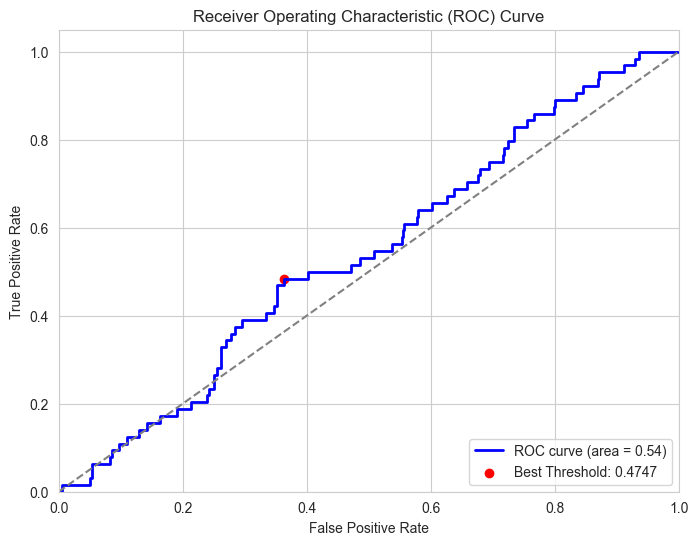

In [33]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)
# Initialise variables to store the best F1 score and the corresponding best threshold
best_f1 = 0
best_threshold = 0.5
best_fpr = 0
best_tpr = 0
#print(roc_auc)
# Iterate over thresholds to find the best one for F1 score
for i, threshold in enumerate(thresholds):
    y_pred = (y_pred_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_fpr = fpr[i]
        best_tpr = tpr[i]

# Print the best F1 score and its corresponding threshold
print(f"Best F1 Score: {best_f1:.4f} at Threshold: {best_threshold:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.scatter(best_fpr, best_tpr, color='red', label=f'Best Threshold: {best_threshold:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Weekly Testing Section (DNN is used based on the performance of the three models above)

In [34]:
data_2=np.load("week_11_data/third_batch_test.npz") # Load the data

In [35]:
X=data_2["X"]

print("# of interactions:", X.shape[0])

XX_trial_test=pd.DataFrame(X)
XX_trial_test.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
print("# of items:", XX['item'].unique().shape[0])

# of interactions: 349573
# of items: 1199


## Preprocessing (Identical to the training earlier)

In [36]:
groups_X_test = XX_trial_test.groupby('user')
groups_X_test = [group for _, group in groups_X_test]

max_rating_global = XX_trial_test['rating'].max()
min_rating_global = XX_trial_test['rating'].min()
avg_rating_global = XX_trial_test['rating'].mean()

### Feature Engineering

In [37]:
# Feature Engineering
test_features_list = []

for group in groups_X_test:
    min_rating = group['rating'].min() # Min rating given by the user
    total_interactions = group.shape[0] # Total number of interactions by the user

    fsti = total_interactions / XX_trial_test['item'].nunique() # The ratio between the number of items rated by the user and the total number of items in the recommender system.
    fsmaxrti = (group['rating'] == max_rating_global).sum() / total_interactions # The ratio between the number of items rated by the user with maximum score and the total number of items in the recommender system.
    fsminrti = (group['rating'] == min_rating_global).sum() / total_interactions # The ratio between the number of items rated by the user with minimum score and the total number of items in the recommender system.
    
    unique_items = group['item'].nunique() # Count how many times each user rated items exactly at their max or min rating

    score = 0
    for item in group['item']:
        score = score + item # Sum of the items' ratings rated by the user

    popularity_score = 0 
    for item in group['item']: 
        if popularity_index.get(item): 
            popularity_score += popularity_index.get(item) # A score reflecting the sum of the popularity of items interacted with by the user.

    rating_variance = group['rating'].var() # The variance of the ratings given by the user

    has_popular_item = 0
    has_unpopular_item = 0
    for item in group['item']: 
        if item in popular_items:
            has_popular_item += 1
        if item in unpopular_items:
            has_unpopular_item += 1
    
    fspi = has_popular_item / len(popular_items) # The ratio between the number of popular items rated by the user and the total number of popular items, K, in the recommender system.
    fspii = has_popular_item / len(group["item"]) # The ratio between the number of popular items rated by the user and the total number of items rated by the user.

    test_features_list.append({
        'min_rating': min_rating,
        'fsti': fsti,
        'fsmaxrti': fsmaxrti,
        'fsminrti': fsminrti,
        'total_interactions': total_interactions,
        'score': score,
        "popularity_score": popularity_score,
        'rating_variance': rating_variance,
        'unique_items': unique_items,
        "fspi": fspi,
        "fspii": fspii,
    })


# Create a DataFrame with the features
features_df_test = pd.DataFrame(test_features_list)

### Normalisation and Testing

In [38]:
X_trial_test = features_df_test
X_trial_test = scaler.transform(X_trial_test)
X_trial_test = pd.DataFrame(X_trial_test)
X_trial_test.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.184896,-0.482952,-1.120666,0.214055,-0.485920,-0.750662,-0.144211,-0.110560,-0.485920,0.493226,2.311555
1,1.128251,-0.516846,0.763094,-0.285671,-0.519673,-0.758813,-0.211439,-0.090170,-0.519673,0.461568,2.490077
2,2.284825,-0.977805,-0.308700,-0.285671,-0.978709,-0.720129,-1.132158,-1.309270,-0.978709,-1.342911,-0.136147
3,-0.028323,-0.767662,-0.398919,-0.285671,-0.769443,-0.479451,-0.879213,-0.100389,-0.769443,-1.089651,-0.465452
4,-0.028323,0.303389,-0.532817,-0.285671,0.297142,0.291490,0.502878,-0.529652,0.297142,0.999746,0.183025


In [39]:
# Predict the labels for the test set
y_trial_test_pred = full_model.predict(X_trial_test)

63/63 [==============================] - 0s 4ms/step


In [40]:
# Apply the best threshold to the predictions
y_final_pred = y_trial_test_pred - best_threshold
y_final_pred

array([[-0.473949  ],
       [-0.47405767],
       [-0.4079429 ],
       ...,
       [-0.46998593],
       [-0.413696  ],
       [-0.47352764]], dtype=float32)

In [41]:
# Save the predictions to a CSV file
answer = pd.DataFrame(y_final_pred)
answer.to_csv('weekly_prediction/week12.csv', index=False, header=False)